**Image Pre-processing Pipeline**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import tqdm


sys.path.append('/home/common/HolschuhLab/Code/')
sys.path.append('/home/common/HolschuhLab/Code/OtherRepos/snappy/')

import NDH_Tools as ndh
from esa_snappy import ProductIO
from esa_snappy import PixelPos, GeoPos
from esa_snappy import GPF, HashMap

input_path = '/home/common/HolschuhLab/Data/Sentinel_Imagery/2025/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3.SAFE/'
post_processing_folder = 'post_processing_folder/'
output_dir = post_processing_folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
base_filename = 'S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3'

input_product = ProductIO.readProduct(input_path)

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 11.0.0, available is 12.0.0.
Please visit http://step.esa.int



**Processing Steps to be Taken**

(1) Apply orbit file

(2) Ellipsoid Correction

(3) Thermal noise removal

(4) Radiometric calibration

(5) Speckle filtering

(6) Terrain correction

(7) Subset



**Applying Orbit File**

In [2]:
#Orbit Correction


orbit_params = HashMap()
orbit_params.put('Orbit Type', 'Sentinel Precise (Auto Download)')
orbit_params.put('Polynomial Degree', '3')
orbit_params.put('ContinueOnFail', 'false')

orbit_applied = GPF.createProduct('Apply-Orbit-File', orbit_params, input_product)
orbit_applied.setName(base_filename + '_Orb')

#save
orbit_applied_filename = output_dir + orbit_applied.getName() + '.tif'
ProductIO.writeProduct(orbit_applied, orbit_applied_filename, 'GeoTIFF')
print("Orbit product written to:", orbit_applied_filename)


100% done.
Orbit product written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb.tif


**Ellipsoid Correction**

In [3]:
ellipsoid_params = HashMap()
ellipsoid_params.put('externalDEMFile', '/home/common/HolschuhLab/Data/Antarctic_Imagery/REMA_Hillshade/REMA_200m_hillshade.nc')
ellipsoid_params.put('mapProjection', 'EPSG:3031')

ellipsoid_corrected_product = GPF.createProduct('Ellipsoid-Correction-GG', ellipsoid_params, orbit_applied)
ellipsoid_corrected_product.setName(base_filename + '_Orb_EC')

#save
ecp_name = output_dir + ellipsoid_corrected_product.getName() + '.tif'
ProductIO.writeProduct(ellipsoid_corrected_product, ecp_name, 'GeoTIFF')
print("Ellipsoid product written to:", ecp_name)


100% done.
Ellipsoid product written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb_EC.tif


**Thermal Noise Removal**

In [4]:
# Noise Removal

tnr_params = HashMap() # remove antenna Thermal Noise (TNR)
tnr_params.put('selectedPolarisations', 'HH') # HH polarization
tnr_params.put('reIntroduceThermalNoise', 'false') # do not add thermal noise back
tnr_product = GPF.createProduct('ThermalNoiseRemoval', tnr_params, ellipsoid_corrected_product)

# remove Border Noise
border_params = HashMap()
nr_product = GPF.createProduct('Remove-GRD-Border-Noise', border_params, tnr_product)

nr_product.setName(base_filename + '_Orb_NR_EC')

nr_filename = output_dir + nr_product.getName() + '.tif'
ProductIO.writeProduct(nr_product, nr_filename, 'GeoTIFF')
print("Step 2 written to:", nr_filename)


100% done.
version = 3.9

100% done.
Step 2 written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb_NR_EC.tif


**Speckle Filtering**

In [5]:
# speckle filtering
speckle_params = HashMap()
speckle_product = GPF.createProduct('Speckle-Filter', speckle_params, nr_product)
speckle_product.setName(base_filename + '_Orb_NR_Spk_EC') # Update name to include _Spk

# save
SP_filename = output_dir + speckle_product.getName() + '.tif'
ProductIO.writeProduct(speckle_product, SP_filename, 'GeoTIFF')
print("Step 3 written to:", SP_filename)

# SP and Calibration (Without BandMaths)
calibration_params = HashMap()
calibrated_product = GPF.createProduct('Calibration', calibration_params, speckle_product)

calibrated_product.setName(base_filename + '_Orb_NR_Spk_Cal_EC')
calibratedSP_filename = output_dir + calibrated_product.getName() + '.tif'
ProductIO.writeProduct(calibrated_product, calibratedSP_filename, 'GeoTIFF')
print("Step 4 written to:", calibratedSP_filename)




100% done.
Step 3 written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb_NR_Spk_EC.tif

100% done.


java.lang.ArrayIndexOutOfBoundsException: Index -1 out of bounds for length 27
	at eu.esa.sar.calibration.gpf.calibrators.Sentinel1Calibrator$CalibrationInfo.getCalibrationVector(Sentinel1Calibrator.java:810)
	at eu.esa.sar.calibration.gpf.calibrators.Sentinel1Calibrator.computeTile(Sentinel1Calibrator.java:598)
	at eu.esa.sar.calibration.gpf.CalibrationOp.computeTile(CalibrationOp.java:195)
	at org.esa.snap.core.gpf.internal.OperatorImage.computeRect(OperatorImage.java:82)
	at javax.media.jai.SourcelessOpImage.computeTile(Unknown Source)
	at com.sun.media.jai.util.SunTileScheduler.scheduleTile(Unknown Source)
	at javax.media.jai.OpImage.getTile(Unknown Source)
	at javax.media.jai.PlanarImage.getData(Unknown Source)
	at com.bc.ceres.glevel.MultiLevelImage.getData(MultiLevelImage.java:64)
	at org.esa.snap.core.dataio.ProductIO.writeTile(ProductIO.java:608)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:580)
	at java.base/java.util.concurrent.ThreadPo

Step 4 written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb_NR_Spk_Cal_EC.tif


**Adding BandMath to speckle filtering and calibration**

In [32]:
from esa_snappy import jpy

# SP filtering w/ Calibration and Bandmaths
bandmath_params = HashMap()

BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
targetBand = BandDescriptor()
targetBand.name = 'Sigma0_HH_8bit'
targetBand.type = 'uint8'
targetBand.expression = 'Sigma0_HH * 255'
targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)

targetBands[0] = targetBand

bandmath_params.put('targetBands', targetBands)

# band_names = calibrated_product.getBandNames()
# for i in range(len(band_names)):
#     print(band_names[i])

# apply BandMaths
bandmath_product = GPF.createProduct('BandMaths', bandmath_params, calibrated_product)

# save output
bandmath_product.setName(base_filename + '_Orb_NR_Spk_Cal_EC_BandMath')
bandmath_filename = output_dir + bandmath_product.getName() + '.tif'
ProductIO.writeProduct(bandmath_product, bandmath_filename, 'GeoTIFF')

print("Step 5 written to:", bandmath_filename)


100% done.


java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayIndexOutOfBoundsException
java.lang.ArrayI

Step 3 written to: post_processing_folder/S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb_NR_Spk_Cal_EC_BandMath.tif


**Loading Image**

('band', 'y', 'x')


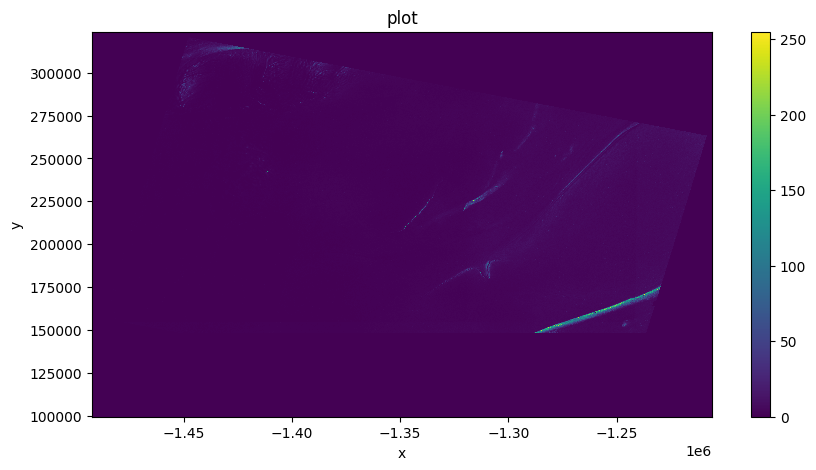

In [34]:
import rioxarray as rxr
import matplotlib.pyplot as plt

# load post processed raster image
relative_data_path = 'S1A_IW_GRDH_1SSH_20250105T050718_20250105T050743_057304_070D00_E5D3_Orb_NR_Spk_Cal_EC_BandMath.tif'
load_data_path = output_dir + relative_data_path
data = rxr.open_rasterio(load_data_path)


print(data.dims)

# plotting
plt.figure(figsize=(10, 5))
data.plot(vmin=0, vmax=255)
plt.title("plot")
plt.show()




In [ ]:
print(data.min().item(), data.max().item())

In [ ]:
plt.hist(data.values.ravel(),np.arange(0,255))